# Modelling lithium plating in PyBaMM

This notebook shows how PyBaMM [8] can be used to model both reversible and irreversible lithium plating.

In [1]:
%pip install "pybamm[plot,cite]" -q    # install PyBaMM if it is not installed
import pybamm
import os

os.chdir(pybamm.__path__[0] + "/..")

Note: you may need to restart the kernel to use updated packages.


The Doyle-Fuller-Newman model [3] is upgraded with three different lithium plating models. Model 1 contains the reversible lithium plating model of O'Kane et al. [5]. Model 2 contains the same model but with the lithium stripping capability removed, making the plating irreversible. Model 3 contains the updated partially reversible plating of O'Kane et al. [6]. The parameters are taken from Chen et al.'s investigation [2] of an LG M50 cell.

In [2]:
# choose models
plating_options = ["reversible", "irreversible", "partially reversible"]
models = {
    option: pybamm.lithium_ion.DFN(options={"lithium plating": option}, name=option)
    for option in plating_options
}

# pick parameters
parameter_values = pybamm.ParameterValues("OKane2022")
parameter_values.update({"Ambient temperature [K]": 268.15})
parameter_values.update({"Upper voltage cut-off [V]": 4.21})
# parameter_values.update({"Lithium plating kinetic rate constant [m.s-1]": 1E-9})
parameter_values.update({"Lithium plating transfer coefficient": 0.5})
parameter_values.update({"Dead lithium decay constant [s-1]": 1e-4})

A series of simple fast charging experiments based on those of Ren et al. [7] is defined here. We first initialise the model at 0% SoC by performing a C/20 discharge (see more details on how to initialise a model from a simulation in [this notebook](../initialize-model-with-solution.ipynb)).

In [3]:
# specify experiments
pybamm.citations.register("Ren2018")

s = pybamm.step.string
experiment_discharge = pybamm.Experiment(
    [
        (
            s("Discharge at C/20 until 2.5 V", period="10 minutes"),
            s("Rest for 1 hour", period="3 minutes"),
        ),
    ]
)

sims_discharge = []
for model in models.values():
    sim_discharge = pybamm.Simulation(
        model, parameter_values=parameter_values, experiment=experiment_discharge
    )
    sol_discharge = sim_discharge.solve(calc_esoh=False)
    model.set_initial_conditions_from(sol_discharge, inplace=True)
    sims_discharge.append(sim_discharge)

And we can now define the different experiments to charge at different C-rates.

In [4]:
C_rates = ["2C", "1C", "C/2", "C/4", "C/8"]
experiments = {}
for C_rate in C_rates:
    experiments[C_rate] = pybamm.Experiment(
        [
            (
                f"Charge at {C_rate} until 4.2 V",
                "Hold at 4.2 V until C/20",
                "Rest for 1 hour",
                "Discharge at 1C until 2.5 V",
                "Rest for 1 hour",
            ) * 3
        ]
    )

Solve the reversible plating model first. The default CasADi [1] solver is used here.

In [5]:
def define_and_solve_sims(model, experiments, parameter_values):
    sims = {}
    for C_rate, experiment in experiments.items():
        sim = pybamm.Simulation(
            model, experiment=experiment, parameter_values=parameter_values
        )
        sim.solve(calc_esoh=False)
        sims[C_rate] = sim

    return sims


sims_reversible = define_and_solve_sims(
    models["reversible"], experiments, parameter_values
)

At t = 226.476 and h = 3.38698e-10, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 235.61 and h = 6.78626e-09, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 106.475 and h = 7.24813e-10, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 55.5152 and h = 9.87331e-09, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 224.786 and h = 4.84352e-10, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 234.922 and h = 3.9483e-09, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 114.935 and h = 5.29609e-10, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 44.7865 and h = 3.27659e-10, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 234.82 and h = 5.48058e-10, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 235.203 and h = 1.55803e-08, the corrector convergence failed repeatedly or with |h| = hmin.
At 

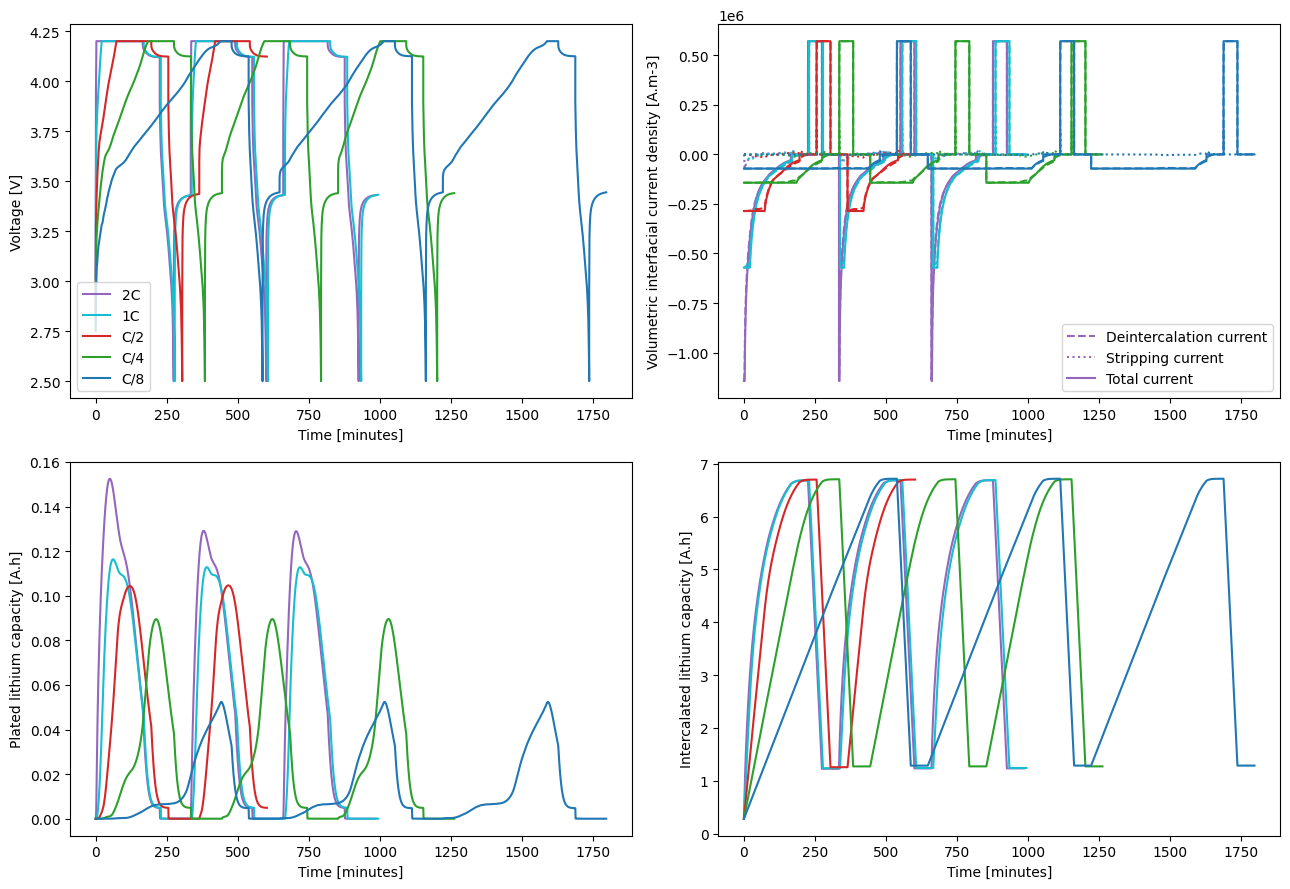

In [6]:
colors = ["tab:purple", "tab:cyan", "tab:red", "tab:green", "tab:blue"]
linestyles = ["dashed", "dotted", "solid"]

param = models["reversible"].param
A = parameter_values.evaluate(param.L_y * param.L_z)
F = parameter_values.evaluate(param.F)
L_n = parameter_values.evaluate(param.n.L)

currents = [
    "X-averaged negative electrode volumetric interfacial current density [A.m-3]",
    "X-averaged negative electrode lithium plating volumetric interfacial current density [A.m-3]",
    "Sum of x-averaged negative electrode volumetric interfacial current densities [A.m-3]",
]


def plot(sims):
    import matplotlib.pyplot as plt

    fig, axs = plt.subplots(2, 2, figsize=(13, 9))
    for (C_rate, sim), color in zip(sims.items(), colors):
        # Isolate final equilibration phase
        #sol = sim.solution.cycles[0].steps[2]
        sol = sim.solution.cycles[0]   
        # Voltage vs time
        t = sol["Time [min]"].entries
        t = t - t[0]
        V = sol["Voltage [V]"].entries
        axs[0, 0].plot(t, V, color=color, linestyle="solid", label=C_rate)

        # Currents
        for current, ls in zip(currents, linestyles):
            j = sol[current].entries
            axs[0, 1].plot(t, j, color=color, linestyle=ls)

        # Plated lithium capacity
        Q_Li = sol["Loss of capacity to negative lithium plating [A.h]"].entries
        axs[1, 0].plot(t, Q_Li, color=color, linestyle="solid")

        # Capacity vs time
        Q_main = (
            sol["Negative electrode volume-averaged concentration [mol.m-3]"].entries
            * F
            * A
            * L_n
            / 3600
        )
        axs[1, 1].plot(t, Q_main, color=color, linestyle="solid")

    axs[0, 0].legend()
    axs[0, 0].set_ylabel("Voltage [V]")
    axs[0, 1].set_ylabel("Volumetric interfacial current density [A.m-3]")
    axs[0, 1].legend(("Deintercalation current", "Stripping current", "Total current"))
    axs[1, 0].set_ylabel("Plated lithium capacity [A.h]")
    axs[1, 1].set_ylabel("Intercalated lithium capacity [A.h]")

    for ax in axs.flat:
        ax.set_xlabel("Time [minutes]")

    fig.tight_layout()

    return fig, axs


    

plot(sims_reversible);

In [7]:
def plot2(sims):
    import matplotlib.pyplot as plt

    fig, axs = plt.subplots(2, 2, figsize=(13, 9))
    for (C_rate, sim), color in zip(sims.items(), colors):
        # Isolate final equilibration phase
        #sol = sim.solution.cycles[0].steps[2]
        sol = sim.solution   
        # Voltage vs time
        t = sol["Throughput capacity [A.h]"].entries
        t = t - t[0]
        V = sol["Voltage [V]"].entries
        axs[0, 0].plot(t, V, color=color, linestyle="solid", label=C_rate)

        # Currents
        c_Li = sol["X-averaged negative lithium plating concentration [mol.m-3]"].entries
        axs[0, 1].plot(t, c_Li, color=color, linestyle="solid")

        # Plated lithium capacity
        Q_Li = sol["Loss of capacity to negative lithium plating [A.h]"].entries
        axs[1, 0].plot(t, Q_Li, color=color, linestyle="solid")
        
        # Plated lithium capacity
        Thickness_Li = sol["X-averaged negative  lithium plating thickness [m]"].entries
        axs[1, 1].plot(t, Thickness_Li, color=color, linestyle="solid")
        # Capacity vs time
        # Q_main = (
        #     sol["Negative electrode volume-averaged concentration [mol.m-3]"].entries
        #     * F
        #     * A
        #     * L_n
        #     / 3600
        # )
        # axs[1, 1].plot(t, Q_main, color=color, linestyle="solid")

    axs[0, 0].legend()
    axs[0, 0].set_ylabel("Voltage [V]")
    #axs[0, 1].set_ylabel("Volumetric interfacial current density [A.m-3]")
    axs[0, 1].set_ylabel("X-averaged negative lithium plating concentration [mol.m-3]")
    #axs[0, 1].legend(("Deintercalation current", "Stripping current", "Total current"))
    axs[1, 0].set_ylabel("Loss of capacity to negative lithium plating [A.h]")
    axs[1, 1].set_ylabel("X-averaged negative  lithium plating thickness [m]")

    for ax in axs.flat:
        ax.set_xlabel("Throughput capacity [A.h]")

    fig.tight_layout()

    return fig, axs

In [8]:
def plot3(sims):
    import matplotlib.pyplot as plt

    fig, axs = plt.subplots(2, 2, figsize=(13, 9))
    for (C_rate, sim), color in zip(sims.items(), colors):
        # Isolate final equilibration phase
        #sol = sim.solution.cycles[0].steps[2]
        sol = sim.solution  
        # Voltage vs time
        t = sol["Time [min]"].entries
        t = t - t[0]
        V = sol["Voltage [V]"].entries
        axs[0, 0].plot(t, V, color=color, linestyle="solid", label=C_rate)

        # Currents
        for current, ls in zip(currents, linestyles):
            j = sol[current].entries
            axs[0, 1].plot(t, j, color=color, linestyle=ls)

        # Plated lithium capacity
        Q_Li = sol["Loss of capacity to negative lithium plating [A.h]"].entries
        axs[1, 0].plot(t, Q_Li, color=color, linestyle="solid")
        
        # Plated lithium capacity
        Thickness_Li = sol["X-averaged negative  lithium plating thickness [m]"].entries
        axs[1, 1].plot(t, Thickness_Li, color=color, linestyle="solid")
        # Capacity vs time
        # Q_main = (
        #     sol["Negative electrode volume-averaged concentration [mol.m-3]"].entries
        #     * F
        #     * A
        #     * L_n
        #     / 3600
        # )
        # axs[1, 1].plot(t, Q_main, color=color, linestyle="solid")

    axs[0, 0].legend()
    axs[0, 0].set_ylabel("Voltage [V]")
    axs[0, 1].set_ylabel("Volumetric interfacial current density [A.m-3]")
    axs[0, 1].legend(("Deintercalation current", "Stripping current", "Total current"))
    axs[1, 0].set_ylabel("Loss of capacity to negative lithium plating [A.h]")
    axs[1, 1].set_ylabel("X-averaged negative  lithium plating thickness [m]")

    for ax in axs.flat:
        ax.set_xlabel("Time [minutes]")

    fig.tight_layout()

    return fig, axs

In [9]:


def plot4(sims):
    import matplotlib.pyplot as plt

    fig, axs = plt.subplots(2, 2, figsize=(13, 9))
    for (C_rate, sim), color in zip(sims.items(), colors):
        # Isolate final equilibration phase
        #sol = sim.solution.cycles[0].steps[2]
        sol = sim.solution  
        # Voltage vs time
        t = sol["Time [min]"].entries
        t = t - t[0]
        V = sol["Voltage [V]"].entries
        axs[0, 0].plot(t, V, color=color, linestyle="solid", label=C_rate)

        # Currents
        for current, ls in zip(currents, linestyles):
            j = sol[current].entries
            axs[0, 1].plot(t, j, color=color, linestyle=ls)

        # Plated lithium capacity
        Q_Li = sol["Loss of capacity to negative lithium plating [A.h]"].entries
        axs[1, 0].plot(t, Q_Li, color=color, linestyle="solid")
        
        # Plated lithium capacity
        Thickness_Li_dead = sol["X-averaged negative dead lithium thickness [m]"].entries
        axs[1, 1].plot(t, Thickness_Li_dead, color=color, linestyle="solid")
        # Capacity vs time
        # Q_main = (
        #     sol["Negative electrode volume-averaged concentration [mol.m-3]"].entries
        #     * F
        #     * A
        #     * L_n
        #     / 3600
        # )
        # axs[1, 1].plot(t, Q_main, color=color, linestyle="solid")

    axs[0, 0].legend()
    axs[0, 0].set_ylabel("Voltage [V]")
    axs[0, 1].set_ylabel("Volumetric interfacial current density [A.m-3]")
    axs[0, 1].legend(("Deintercalation current", "Stripping current", "Total current"))
    axs[1, 0].set_ylabel("Loss of capacity to negative lithium plating [A.h]")
    axs[1, 1].set_ylabel("X-averaged negative dead lithium thickness [m]")

    for ax in axs.flat:
        ax.set_xlabel("Time [minutes]")

    fig.tight_layout()

    return fig, axs

In [10]:

def plot5(sims):
    import matplotlib.pyplot as plt

    fig, axs = plt.subplots(2, 2, figsize=(13, 9))
    for (C_rate, sim), color in zip(sims.items(), colors):
        # Isolate final equilibration phase
        #sol = sim.solution.cycles[0].steps[2]
        sol = sim.solution  
        # Voltage vs time
        t = sol["Time [min]"].entries
        t = t - t[0]
        V = sol["Voltage [V]"].entries
        axs[0, 0].plot(t, V, color=color, linestyle="solid", label=C_rate)

        # Currents
        for current, ls in zip(currents, linestyles):
            j = sol[current].entries
            axs[0, 1].plot(t, j, color=color, linestyle=ls)

        # Plated lithium capacity
        Q_Li = sol["Loss of lithium to negative lithium plating [mol]"].entries
        axs[1, 0].plot(t, Q_Li, color=color, linestyle="solid")
        
        # Plated lithium capacity
        Thickness_Li_dead = sol["X-averaged negative dead lithium thickness [m]"].entries
        axs[1, 1].plot(t, Thickness_Li_dead, color=color, linestyle="solid")
        # Capacity vs time
        # Q_main = (
        #     sol["Negative electrode volume-averaged concentration [mol.m-3]"].entries
        #     * F
        #     * A
        #     * L_n
        #     / 3600
        # )
        # axs[1, 1].plot(t, Q_main, color=color, linestyle="solid")

    axs[0, 0].legend()
    axs[0, 0].set_ylabel("Voltage [V]")
    axs[0, 1].set_ylabel("Volumetric interfacial current density [A.m-3]")
    axs[0, 1].legend(("Deintercalation current", "Stripping current", "Total current"))
    axs[1, 0].set_ylabel("Loss of lithium to negative lithium plating [mol]")
    axs[1, 1].set_ylabel("X-averaged negative dead lithium thickness [m]")

    for ax in axs.flat:
        ax.set_xlabel("Time [minutes]")

    fig.tight_layout()

    return fig, axs

In [11]:
model.variables

{'Time [s]': Time(-0x24b101f165201bdb, time, children=[], domains={}),
 'Time [min]': Multiplication(-0x7c1a02db7ee4d879, *, children=['0.016666666666666666', 'time'], domains={}),
 'Time [h]': Multiplication(-0x28d6d8d9e93b7b38, *, children=['0.0002777777777777778', 'time'], domains={}),
 'x [m]': SpatialVariable(0x29bb4ac13fb92819, x, children=[], domains={'primary': ['negative electrode', 'separator', 'positive electrode'], 'secondary': ['current collector']}),
 'x_n [m]': SpatialVariable(-0x176fd7ce96f691dd, x_n, children=[], domains={'primary': ['negative electrode'], 'secondary': ['current collector']}),
 'x_s [m]': SpatialVariable(0x3ced5a01251ff5d2, x_s, children=[], domains={'primary': ['separator'], 'secondary': ['current collector']}),
 'x_p [m]': SpatialVariable(0x33ca03dd46653fc2, x_p, children=[], domains={'primary': ['positive electrode'], 'secondary': ['current collector']}),
 'r_n [m]': SpatialVariable(0x447f5144d31d95c5, r_n, children=[], domains={'primary': ['negativ

The results show both similarities and differences with those of Ren et al. [7]. Notably, unlike Ren et al., this model uses equations [5] that result in a small but finite amount of plated lithium being present in the steady state.

Now solve the irreversible plating model and see how it compares.

In [12]:
sims_irreversible = define_and_solve_sims(
    models["irreversible"], experiments, parameter_values
)

At t = 480.851 and h = 2.26768e-17, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 300.105 and h = 1.65289e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 502.633 and h = 1.64237e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 316.673 and h = 4.50307e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 506.728 and h = 3.21192e-18, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 318.458 and h = 1.25236e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 499.878 and h = 2.66189e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 310.184 and h = 1.52214e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 473.982, repeated recoverable residual errors.
At t = 233.982 and h = 1.94598e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 278.726 and h = 9.70651e-15, the correc

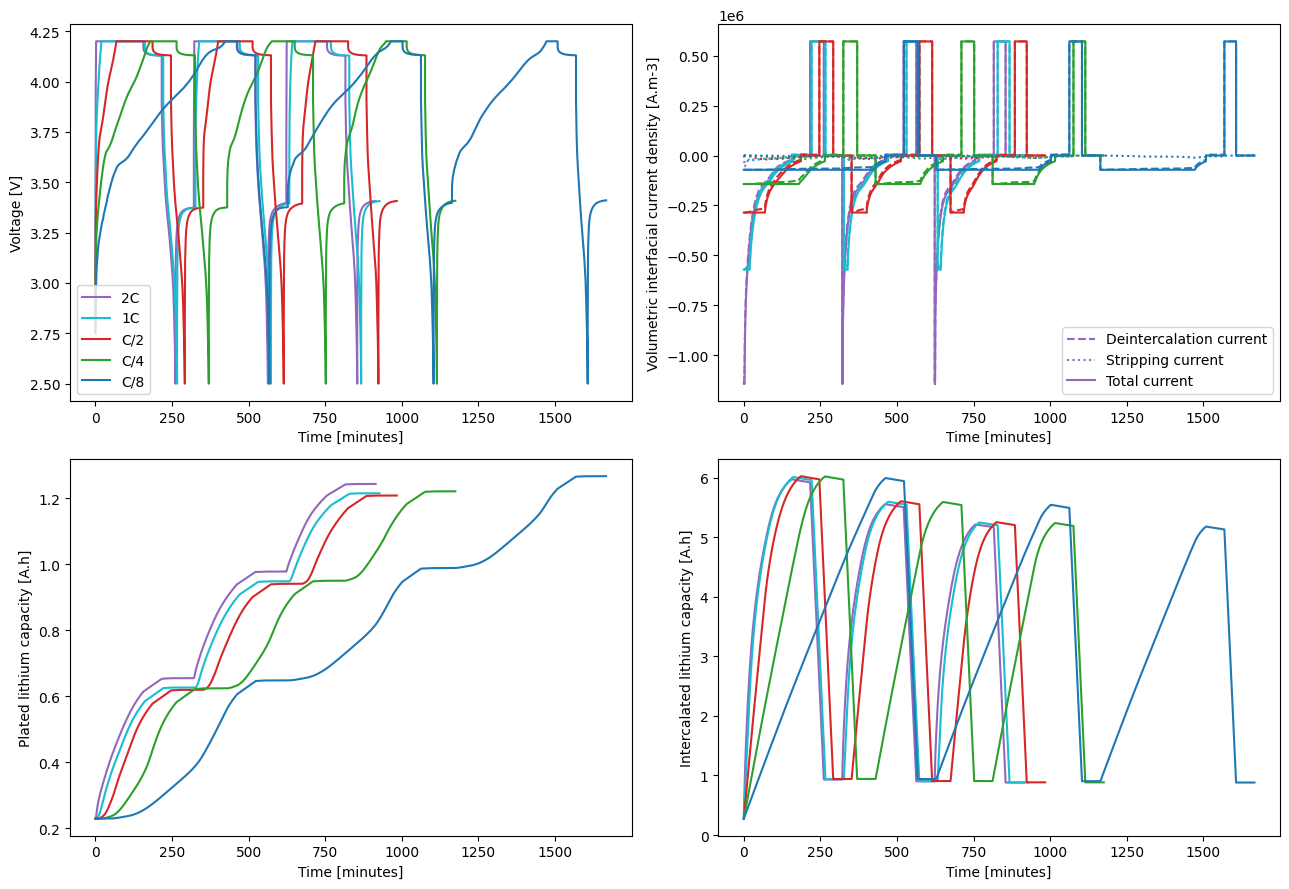

In [13]:
plot(sims_irreversible);

Unlike in the reversible case, there is no steady state and the capacity degrades quickly. The lithium inventory decreases by around 40 mAh in just an hour, which is unrealistic. The low temperature fast charge simulations are run one more time, with the partially reversible plating model.

In [14]:
sims_partially_reversible = define_and_solve_sims(
    models["partially reversible"], experiments, parameter_values
)

At t = 248.342 and h = 5.64064e-10, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 251.799 and h = 4.09747e-10, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 263.627 and h = 3.54024e-09, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 252.173 and h = 3.54394e-10, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 249.996 and h = 5.45281e-10, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 252.688 and h = 4.82686e-10, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 248.007 and h = 3.01081e-09, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 236.771 and h = 3.48146e-10, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 254.29 and h = 5.30559e-09, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 247.851 and h = 1.57585e-10, the corrector convergence failed repeatedly or with |h| = hmin.
A

In [15]:
sims_partially_reversible["2C"].solution.cycles[0]["Throughput capacity [A.h]"].entries

array([ 5.03730469,  5.20397136,  5.37063803,  5.45938105,  5.45938105,
        5.61238095,  5.74990469,  5.87604818,  5.99287674,  6.10221766,
        6.20557329,  6.30386809,  6.39779726,  6.48781637,  6.57407349,
        6.65689497,  6.73642789,  6.81294608,  6.88674886,  6.95788983,
        7.02663647,  7.0930474 ,  7.15716135,  7.21910742,  7.2789151 ,
        7.33656981,  7.39220772,  7.44608096,  7.49817464,  7.54867894,
        7.59766696,  7.64513646,  7.69123924,  7.73606997,  7.7795293 ,
        7.82176666,  7.86291595,  7.90292798,  7.94189873,  7.97987261,
        8.01688847,  8.05296887,  8.08814695,  8.12244778,  8.15598579,
        8.18881837,  8.22088843,  8.25221846,  8.28289114,  8.31293087,
        8.34229649,  8.37097711,  8.39915485,  8.42673701,  8.45378735,
        8.48030399,  8.50635295,  8.53194614,  8.55699257,  8.58156481,
        8.60573477,  8.62950616,  8.65286999,  8.67586617,  8.69847699,
        8.7206941 ,  8.74260891,  8.76418463,  8.78542281,  8.80

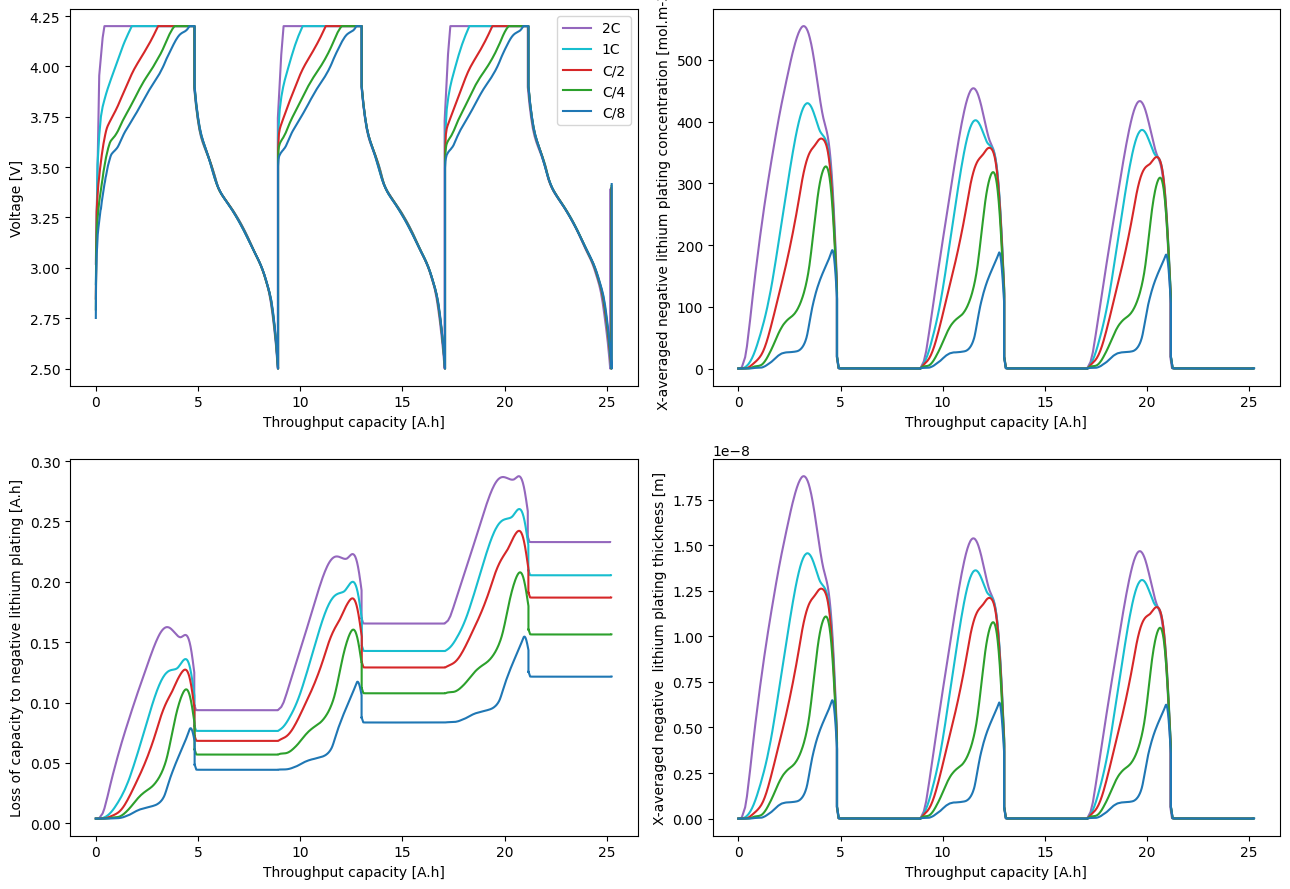

In [16]:
plot2(sims_partially_reversible);

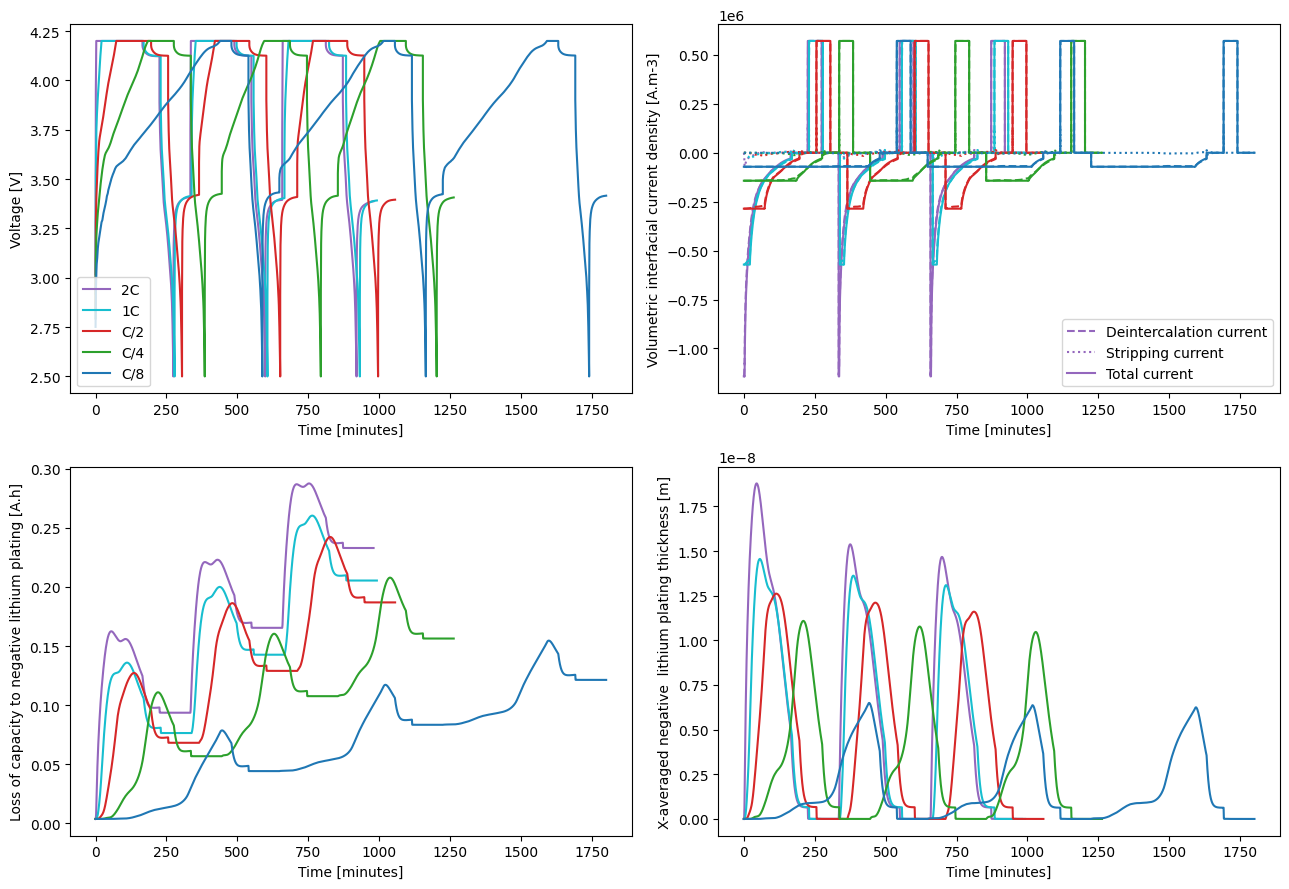

In [17]:
plot3(sims_partially_reversible);

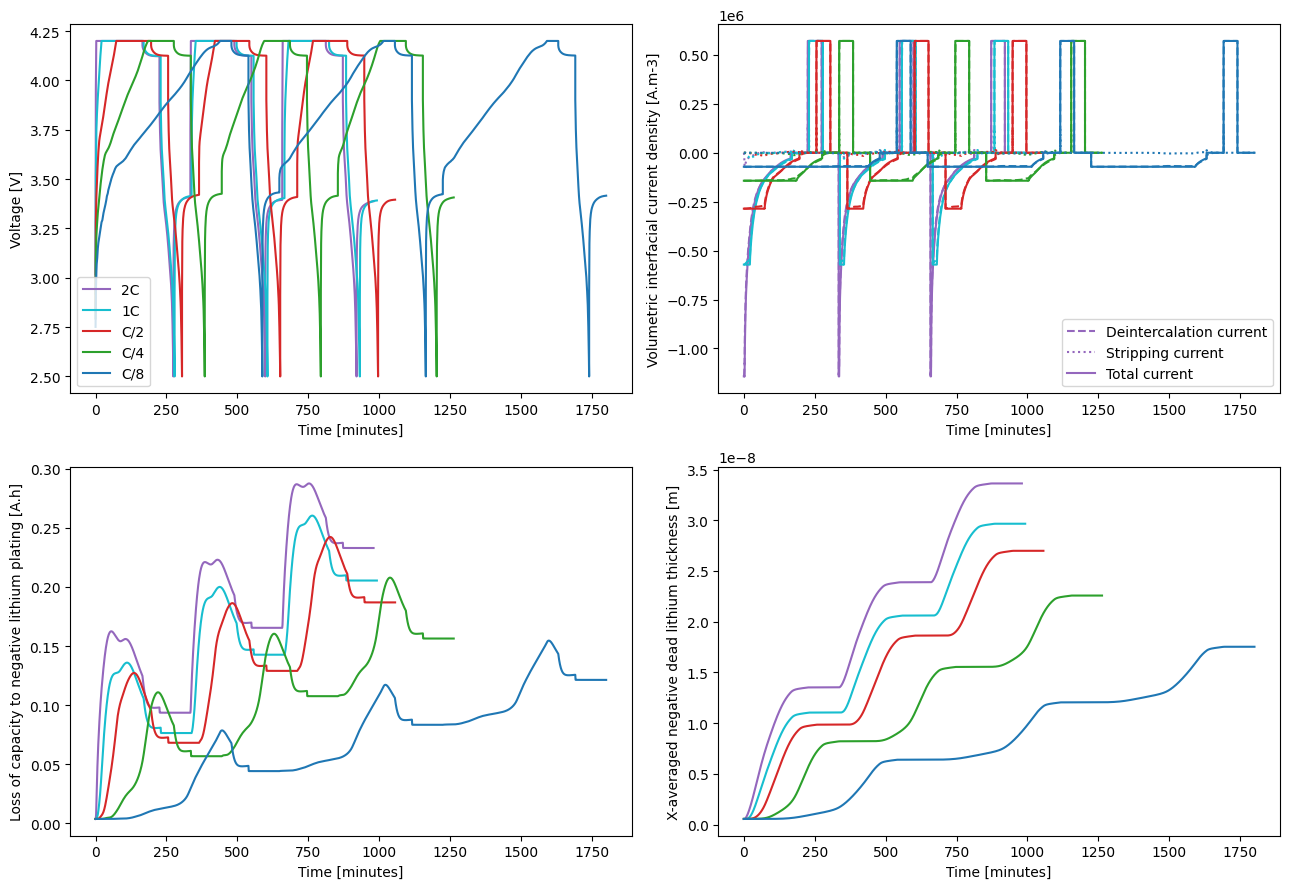

In [18]:
plot4(sims_partially_reversible);

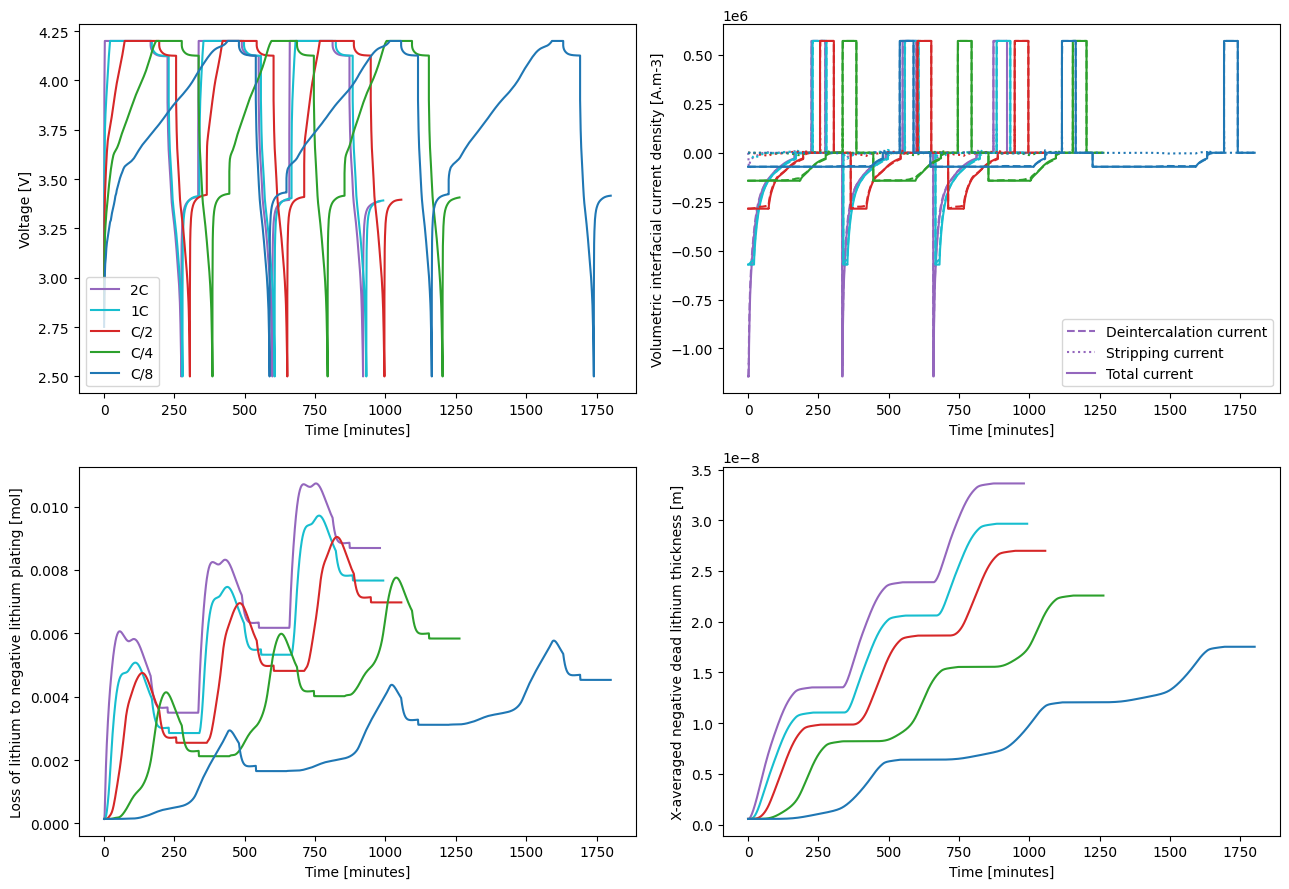

In [19]:
plot5(sims_partially_reversible);

The partially reversible plating model has features of both the reversible and irreversible models, which is reflected in the results. The plated lithium capacity decreases with time as lithium is reversibly stripped, but the final plated lithium capacity now depends on charge rate, indicating that some lithium was irreversibly plated during charge.

# References

In [20]:
pybamm.print_citations()

[1] Joel A. E. Andersson, Joris Gillis, Greg Horn, James B. Rawlings, and Moritz Diehl. CasADi – A software framework for nonlinear optimization and optimal control. Mathematical Programming Computation, 11(1):1–36, 2019. doi:10.1007/s12532-018-0139-4.
[2] Von DAG Bruggeman. Berechnung verschiedener physikalischer konstanten von heterogenen substanzen. i. dielektrizitätskonstanten und leitfähigkeiten der mischkörper aus isotropen substanzen. Annalen der physik, 416(7):636–664, 1935.
[3] Chang-Hui Chen, Ferran Brosa Planella, Kieran O'Regan, Dominika Gastol, W. Dhammika Widanage, and Emma Kendrick. Development of Experimental Techniques for Parameterization of Multi-scale Lithium-ion Battery Models. Journal of The Electrochemical Society, 167(8):080534, 2020. doi:10.1149/1945-7111/ab9050.
[4] Marc Doyle, Thomas F. Fuller, and John Newman. Modeling of galvanostatic charge and discharge of the lithium/polymer/insertion cell. Journal of the Electrochemical society, 140(6):1526–1533, 1993. 